In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score

pd.options.display.max_columns = 100

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [2]:
# Attribute                        Domain
# -------------------------------------------
# 1. Sample code number            id number
# 2. Clump Thickness               1 - 10
# 3. Uniformity of Cell Size       1 - 10
# 4. Uniformity of Cell Shape      1 - 10
# 5. Marginal Adhesion             1 - 10
# 6. Single Epithelial Cell Size   1 - 10
# 7. Bare Nuclei                   1 - 10
# 8. Bland Chromatin               1 - 10
# 9. Normal Nucleoli               1 - 10
# 10. Mitoses                      1 - 10
# 11. Class:                       (2 for benign, 4 for malignant)

In [43]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    print('=' * 20)
    print(f'f1-score: {f1_score(y_test, y_predict) * 100:<10.3f}') 
    print(f'roc-auc: {roc_auc_score(y_test, y_predict) * 100:<10.3f}') 
    print(f'recall: {recall_score(y_test, y_predict, average="binary") * 100:<10.3f}') 
    print(f'precision: {precision_score(y_test, y_predict, average="binary") * 100:<10.3f}')

In [3]:
columns = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 
           'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 
           'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

In [4]:
df = pd.read_csv("./breast-cancer-wisconsin.data")
df.columns = columns
df.drop('Sample code number', axis=1, inplace=True)

In [5]:
df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,4,4,5,7,10,3,2,1,2
1,3,1,1,1,2,2,3,1,1,2
2,6,8,8,1,3,4,3,7,1,2
3,4,1,1,3,2,1,3,1,1,2
4,8,10,10,8,7,10,9,7,1,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Clump Thickness              698 non-null    int64 
 1   Uniformity of Cell Size      698 non-null    int64 
 2   Uniformity of Cell Shape     698 non-null    int64 
 3   Marginal Adhesion            698 non-null    int64 
 4   Single Epithelial Cell Size  698 non-null    int64 
 5   Bare Nuclei                  698 non-null    object
 6   Bland Chromatin              698 non-null    int64 
 7   Normal Nucleoli              698 non-null    int64 
 8   Mitoses                      698 non-null    int64 
 9   Class                        698 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [7]:
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

Clump Thickness: [ 5  3  6  4  8  1  2  7 10  9]
Uniformity of Cell Size: [ 4  1  8 10  2  3  7  5  6  9]
Uniformity of Cell Shape: [ 4  1  8 10  2  3  5  6  7  9]
Marginal Adhesion: [ 5  1  3  8 10  4  6  2  9  7]
Single Epithelial Cell Size: [ 7  2  3  1  6  4  5  8 10  9]
Bare Nuclei: ['10' '2' '4' '1' '3' '9' '7' '?' '5' '8' '6']
Bland Chromatin: [ 3  9  1  2  4  5  7  8  6 10]
Normal Nucleoli: [ 2  1  7  4  5  3 10  6  9  8]
Mitoses: [ 1  5  4  2  3  7 10  8  6]
Class: [2 4]


In [8]:
df.loc[df['Bare Nuclei'] == '?', 'Bare Nuclei'] = '0'
df['Bare Nuclei'] = df['Bare Nuclei'].apply(int)
df.loc[df['Bare Nuclei'] == 0, 'Bare Nuclei'] = df['Bare Nuclei'].median()
df['Class'] = np.where(df['Class'] == 4, 1, 0)

In [9]:
df['Class'].value_counts(normalize=True)

0    0.654728
1    0.345272
Name: Class, dtype: float64

In [10]:
# df['high_values'] = (df.drop('Class', axis=1).sum(axis=1) > 45).astype('uint8')
# df.groupby('high_values')['Class'].value_counts(normalize=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], 
                                                    random_state=42, test_size=0.33)

In [12]:
mod1 = LGBMClassifier(random_state=42)

In [13]:
mod1.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [14]:
y_pred = mod1.predict(X_test)

In [44]:
evaluate_results(y_test, y_pred)

Classification results:
f1-score: 95.858    
roc-auc: 97.377    
recall: 98.780    
precision: 93.103    


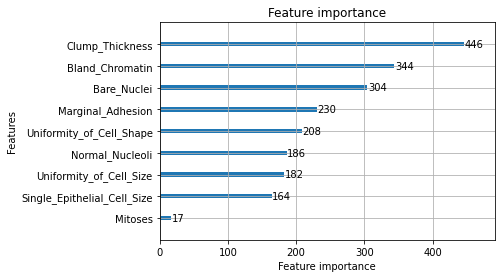

In [16]:
lgbm.plot_importance(mod1)
plt.show()

## PU learning

In [46]:
mod_df = df.copy()

In [65]:
pos_ind = np.where(mod_df['Class'].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)

In [66]:
positive_perc = 0.30
pos_sample_len = int(np.ceil(positive_perc * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 73/241 as positives and unlabeling the rest


In [67]:
mod_df['class_test'] = -1
mod_df.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_df.iloc[:,-1].value_counts())

target variable:
 -1    625
 1     73
Name: class_test, dtype: int64


In [68]:
mod_df.sample(5)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,class_test
535,5,1,1,1,2,1,3,1,1,0,-1
52,5,5,5,8,10,8,7,3,7,1,-1
188,1,2,3,1,2,1,3,1,1,0,-1
576,1,1,1,1,2,1,2,1,1,0,-1
619,3,1,1,1,2,1,2,1,1,0,-1


In [69]:
x_data = mod_df.iloc[:,:-2].values # just the X 
y_labeled = mod_df['class_test'].values # new class (just the P & U)
y_positive = mod_df['Class'].values # original class

In [70]:
mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['class_test']==-1][:len(mod_df[mod_df['class_test']==1])]
sample_test = mod_df[mod_df['class_test']==-1][len(mod_df[mod_df['class_test']==1]):]
pos_sample = mod_df[mod_df['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(73, 11) (73, 11)


In [71]:
model = LGBMClassifier(random_state=42)

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1-score: 95.699    
roc-auc: 96.401    
recall: 94.180    
precision: 97.268    
